# Detection of an unknown pulsar and measurement of its period

In [189]:
# Preamble and imports
from __future__ import (print_function, absolute_import, division)

import os
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
from math import pi
from scipy.signal import find_peaks

%matplotlib inline

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1. Functions
### 1.1 Importing data

In [190]:
# Get the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP", "FFT")

def get_header(file_name):
    """
    Function that reads in the header files.
    
    @param file_name :: name of the file
    
    @returns :: contents of header file as array
                of lines
    """
    
    file_name = file_name + '.hdr'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        lines = dfile.readlines()
        for i, line in enumerate(lines):
            lines[i] = line.strip()
    
    return lines


def get_data(file_name):
    """
    Function that returns the data in the files.
    
    @param file_name :: name of the file
    
    @returns :: contents of the data file
                in one numpy array
    """
    
    file_name = file_name + '.dat'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        data = np.fromfile(dfile, dtype='b')
    
    return data

### 1.2 Demonstration of Fourier Transform using Simulated data

In [191]:
def generate_times(dt, npts):
    """
    Generate the times for the demo.
    
    @param dt :: interval between times
    @param npts :: number of time points
    
    @returns :: array of times
    """

    times = np.linspace(0,(npts-1)*dt,npts)
    
    return times

def generate_signal(times, period):
    """
    Generates the fake signal.
    
    @param times :: array of times
    @param period :: period of the signal
    
    @returns :: fake signal
    """
    
    fake_signal = np.sin(2*pi*times/period)
    
    return fake_signal
    
def generate_noise(npts):
    """
    Generates random noise.
    
    @param npts :: number of points
    
    @returns :: random distributed noise
    """
    
    random_noise = np.random.normal(0,20,npts)
    
    return random_noise

### 1.3 Plotting the 'time series' & 'simulated data'

In [192]:
def raw_plot(times, raw_bytes, fake_signal):
    """
    Plots the raw simulated data with the signal.
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with the data
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Simulated noise plus sinusoidal signal")


def signal_plot(times, raw_bytes, fake_signal):
    """
    Signal plot of the data (zoomed in)
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with data zoomed in
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Zoomed to show signal amplitude")
    plt.xlim(0,5)
    plt.ylim(-3,3)
    
def time(data_header, data):
    """
    Plots the input data as a function of time
    
    @data_header :: header file with info about "sampling_perion"
    @data :: file with the input data
    
    @return :: plot of the amplitude as a function of time
            :: integration time
    """
    sampling_period = float(data_header[-2][5:-1])              # period over which the data is sampled (ms)
    int_time        = sampling_period*len(data)*(pow(10, -3))   # time required for integration
    period_array    = np.linspace(0, int_time, num=len(data))   # linearly spaced time array
    
    plt.figure(figsize=(10,3))
    plt.plot(period_array, data, color = 'green', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    
    return int_time

### 1.4 Calculation and Plots of the Fourier Transform of the Pulsar data

In [193]:
def fourier_transform(raw_bytes):
    """
    Fourier transforms data.
    
    @param raw_bytes :: the data
    
    @returns :: the power of the fourier transformed
                data
    """
    
    ft = np.fft.rfft(raw_bytes)
    power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)
    return power

def frequencyArray(power, int_time, limits):
    """
    Calculates the frequency array for the corresponding  power array
    Eliminates the regular spikes observed at 50 Hz :: Reason yet to be resolved
    
    @param power :: power array from the  fft
    @param int_time :: integration time for the corresponding pulsar
    
    @returns :: frequency array for the calibration of x-axis
    """
    # Starting point of the frequency array
    freq_start_pt   = 1/int_time                                
    freq_array = np.linspace(freq_start_pt, freq_start_pt*len(power), num=len(power))
   
    # k corresponding to the frequency to be eliminated
    for i in range(len(limits)):
        a = np.where(((freq_array >= limits[i][0]) & (freq_array <=limits[i][1]))) 
        freq_array = np.delete(freq_array, a)                        
        power = np.delete(power, a)  

    return freq_array, power
    
def findingPeaksPlot(dist, power, freq, x):
    """
    Function finds the peaks in the plot
    
    @param power :: power spectrum with peaks
    @param  dist :: allows to input minimum distance required between peaks
    @param     x :: pulsar number  
    
    @returns        :: Plot with the peaks
             period :: Period of the Pulsar with RFI            -|
          p_deleted :: RFI points in the period array            |--> result   
         period_new :: True array with only 'Period' points      |       
           outliers :: Gives the indicies of the outlier points _|                   
    """
    # finds the peaks and the period == distance between peaks
    peak, _ = find_peaks(power, distance=dist)
    period = 1/(np.diff(freq[peak]))
    
    # calculting the indicies and periods of the outliers
    idxOutliers     = np.where(abs(period - np.mean(period)) > 1 * np.std(period));
    periodOutliers  = period[idxOutliers];
    period_new      = np.delete(period, idxOutliers);
    
    # putting it all together
    result = np.array([period, idxOutliers, periodOutliers, period_new])
    
    # plots the data 
    plt.figure(figsize=(7,7))
    plt.plot(freq[peak], power[peak], "ro")
    plt.plot(freq, power, 'g-')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power spectrum: Pulsar {}".format(x))
    plt.tight_layout()
    return result, freq[peak]

### 1.5 Cutting noise and Correncting the harmonics number

In [194]:
def sliceAfter(f, p, m):
    """
    Function slices the arrays of frequency and power as per input value (m, n, & o)
    
    @param f :: Frequency arrays for the pulsar
    @param p :: Power arrays for the pulsar
    @param m :: frequency value at which the pulsars are sliced
    
    @returns f_ :: sliced frequency arrays
             p_ :: sliced power arrays  
    """
    # index values at which the arrays are being sliced
    idxDes = np.where(f < m);
    
    f_ = f[idxDes];
    p_ = p[idxDes];
    
    return f_, p_

def removeNoise(f1, p1, x):
    """
    Function removes the noise from pulsar 2
    
    @param      f1 :: freuency array of pulsar 2
    @param      p1 :: power array of pulsar 2
    
    @returns f1new :: new frequncy array with noise eliminated
             p1new :: new power array with noise eliminated        
    """
    idxKeep = np.where(p1 > x)
    p1new = p1[idxKeep]
    f1new = f1[idxKeep]
    
    return f1new, p1new

def correting_harmonic(f_peak, x, m):
    """
    corrects the harmonic number and plots the corrected graph
    
    @param f_peak :: frequency values of the peak
    @param m :: thershold for difference between peak frequencies
    @param x :: pulsar number
    
    @returns new_harmonic :: new harmonics arrays
    @returns n :: total number of harmonics
    """
    harmonic = np.linspace(1, len(f_peak), num=len(f_peak))

    # calculates the frequencies peaks' differences
    diff_freq = np.diff(f_peak)
    
    # find indicies with frequncy > m
    idx_diff = np.where(diff_freq > m)[0]
    
    new_harmonic = harmonic
    # changes the harmonic arrays
    for i in range(0, len(idx_diff)):
        new_harmonic = np.concatenate((new_harmonic[:(idx_diff[i]+1)],
                                  new_harmonic[(idx_diff[i]+1):]+1))
    # plots the corrected graph
    plt.figure(figsize=(7,7))
    plt.plot(f_peak, new_harmonic,  "ro", label='Corrected Harmonics')
    plt.plot(f_peak, harmonic,  "gX", label='Original Harmonics')
    plt.plot(f_peak[idx_diff], harmonic[idx_diff],  "m^", label='Points of increment')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("No. of Harmonic")
    plt.title("Frequency vs Harmonics Number: Pulsar {}".format(x))
    plt.legend(loc='upper left', prop={'size': 15})
    plt.show()
    
    # calculates the last harmonic number
    n = new_harmonic[-1]
    
    return new_harmonic, n

## 2. Kowalsky, Analysis.

### 2.1 Calculating the Fourier Transform of the Simulated Data

Fake data has been simulated upon which a Fourier transform will be performed. The excersice is intructive to understand the use of Fourier Transform.

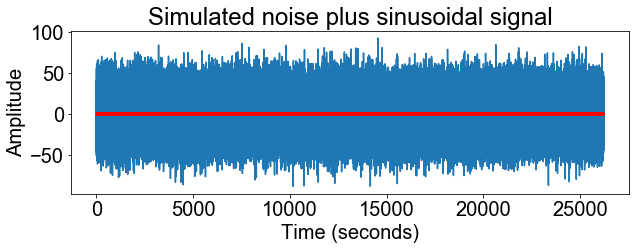

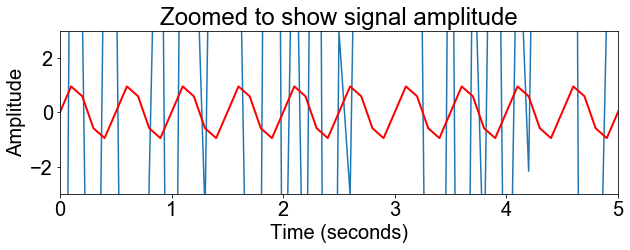

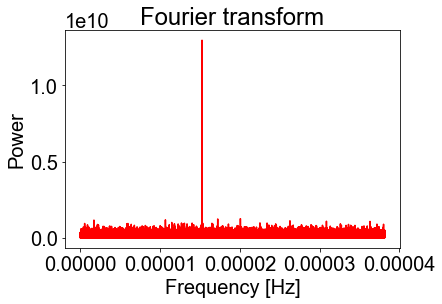

In [195]:
# Choose time interval and number of points
dt = 0.1
npts = 262144
period = 0.5

# Generate data
times           = generate_times(dt, npts)
fake_signal     = generate_signal(times, period)
noise           = generate_noise(npts)
raw_bytes       = noise + fake_signal

# Plot data
raw_plot(times, raw_bytes, fake_signal)
signal_plot(times, raw_bytes, fake_signal)
p = fourier_transform(raw_bytes)

# plotting the data
fig, ax = plt.subplots()
fake_frequency  = np.linspace((1/sum(times)), len(p)*(1/sum(times)), num=len(p))
plt.plot(fake_frequency, p, 'r-')
plt.xlabel("Frequency [Hz]")
# format the x axis such that labels don't overlap
plt.ylabel("Power")
plt.title("Fourier transform")
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

### 2.2 Plotting the time series for the pulsars

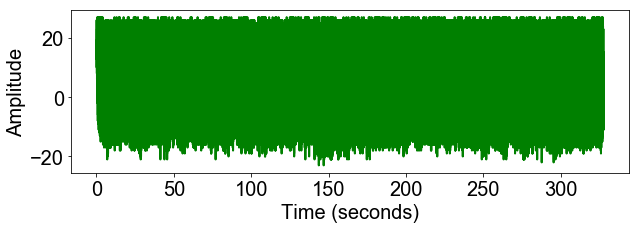

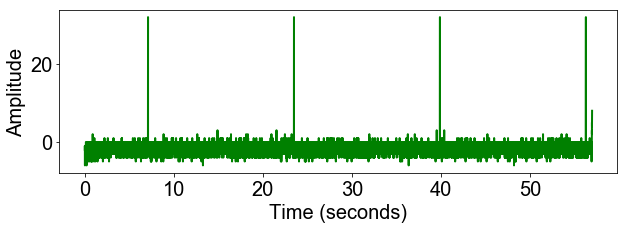

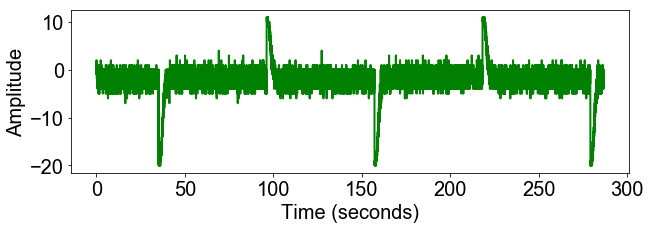

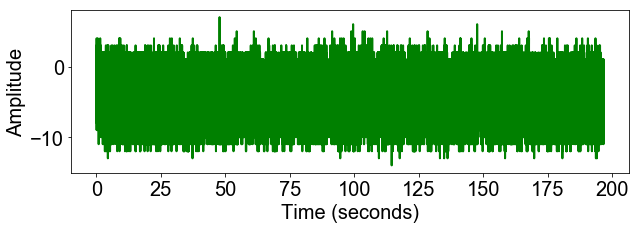

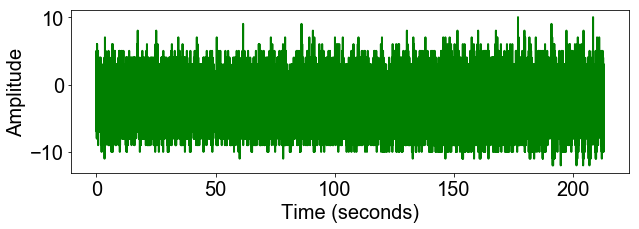

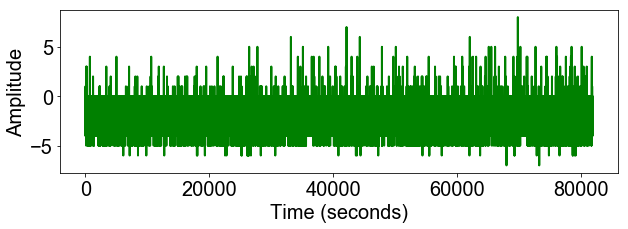

In [222]:
# reading the data
psr0 = get_data('psr0');
psr1 = get_data('psr1');
psr2 = get_data('psr2');
psr3 = get_data('psr3');
psr4 = get_data('psr4');
psr5 = get_data('psr5');

# reading the header files
psr0_header = get_header('psr0');
psr1_header = get_header('psr1');
psr2_header = get_header('psr2');
psr3_header = get_header('psr3');
psr4_header = get_header('psr4');
psr5_header = get_header('psr5');

# plotting the time series
int_time0 = time(psr0_header, psr0)
int_time1 = time(psr1_header, psr1)
int_time2 = time(psr2_header, psr2)
int_time3 = time(psr3_header, psr3)
int_time4 = time(psr4_header, psr4)
int_time5 = time(psr5_header, psr5)

# resolution of the frequency - used as error estimate later
res_f_0 = 1/int_time0 
res_f_1 = 1/int_time1
res_f_2 = 1/int_time2
res_f_3 = 1/int_time3
res_f_4 = 1/int_time4
res_f_5 = 1/int_time5


### 2.3 Plotting the 'Fourier Transformed' Power Spectrum of all pulsars 

The fourier transform of the time series is plotted. The peaks in the frequency spectrum are identified and used to calculated the period and width (detailed in the next sections).

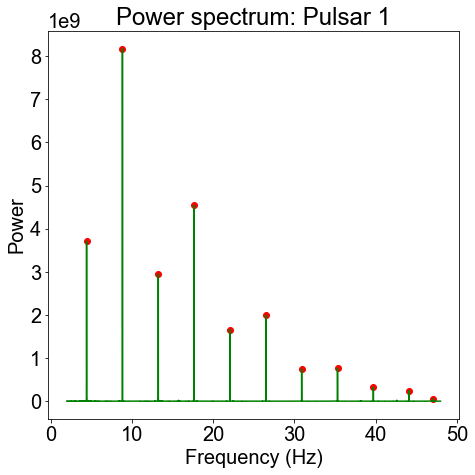

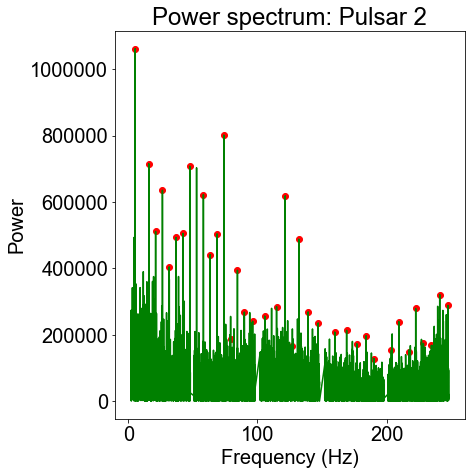

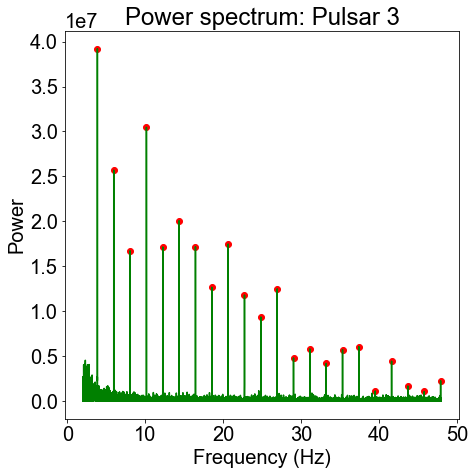

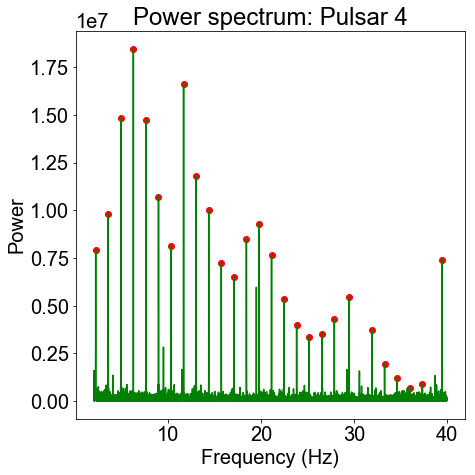

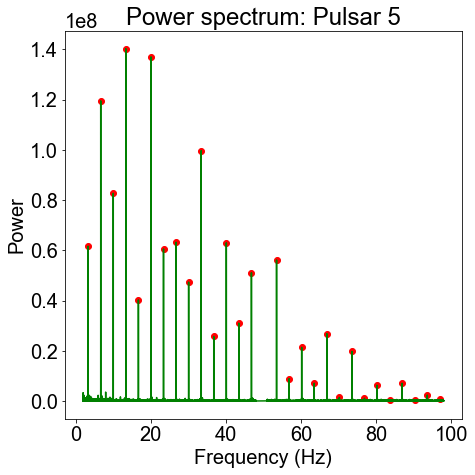

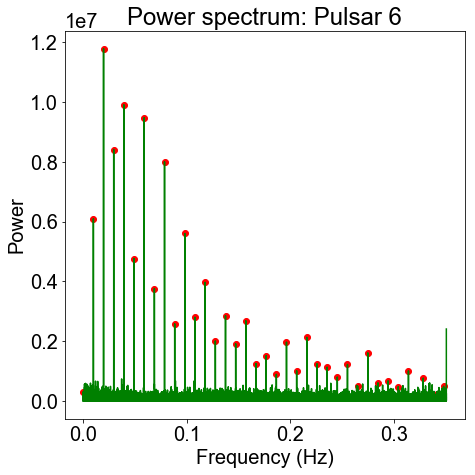

In [345]:
# calculates the power to plot the power spectrum using FFT
power0 = fourier_transform(psr0)[1:]
power1 = fourier_transform(psr1)[1:]
power2 = fourier_transform(psr2)[100:]
power3 = fourier_transform(psr3)[100:]
power4 = fourier_transform(psr4)[1:]
power5 = fourier_transform(psr5)[1:]

# eliminates suspicious cuts observed in the data
cuts = [[0, 2],[48, 51], [98,102],[148, 152],[198,201],[248, 251],[298, 301]]

# calcultes the frequency and power array to plot after elimiting cuts
freq0, power0 = frequencyArray(power0, int_time0, cuts)   
freq1, power1 = frequencyArray(power1, int_time1, cuts)
freq2, power2 = frequencyArray(power2, int_time2, cuts)
freq3, power3 = frequencyArray(power3, int_time3, cuts)
freq4, power4 = frequencyArray(power4, int_time4, cuts)
freq5, power5 = frequencyArray(power5, int_time5, cuts[1:])

# removes noise from pulsar 2
f1_, p1_ = removeNoise(freq1, power1, 100000)

# calculetes the points at which the arrays need to be sliced
f2_, p2_ = sliceAfter(freq2, power2, 50);
f3_, p3_ = sliceAfter(freq3, power3, 40);
f4_, p4_ = sliceAfter(freq4, power4, 100);
   
# finds the periods, outlier's false harmonic, period of the outlier, new_period array
result0, f_peak0      = findingPeaksPlot(900, power0, freq0, '1')
result1i, f_peak1i    = findingPeaksPlot(300, power1, freq1, '2')
result2, f_peak2ii    = findingPeaksPlot(600, p2_, f2_, '3')
result3, f_peak3ii    = findingPeaksPlot(250, p3_, f3_, '4')
result4, f_peak4ii    = findingPeaksPlot(700, p4_, f4_, '5')
result5, f_peak5      = findingPeaksPlot(800, power5, freq5, '6')

### 2.4 Correcting the number of harmonics

[ 5.26297323  5.28051647  5.28051647  5.28051647  5.26297323  5.35068945
  5.26297323  5.28051647 10.56103295  5.26297323  5.28051647  5.28051647
  5.28051647  5.26297323  5.35068945  6.42082734  9.40317884  9.10494369
  6.71906249  5.29805972  5.26297323  7.17518684  7.80674362 12.80656819
  9.19265991  7.91200309  7.1225571   6.10504895 13.45566822  5.78927055
  7.73657065  5.36823269  5.98224624  6.19276517  6.42082734  6.4032841 ]


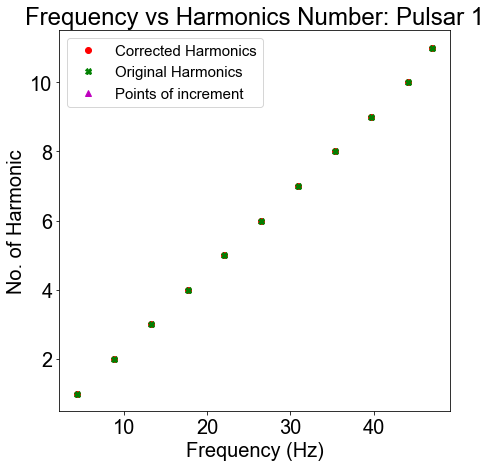

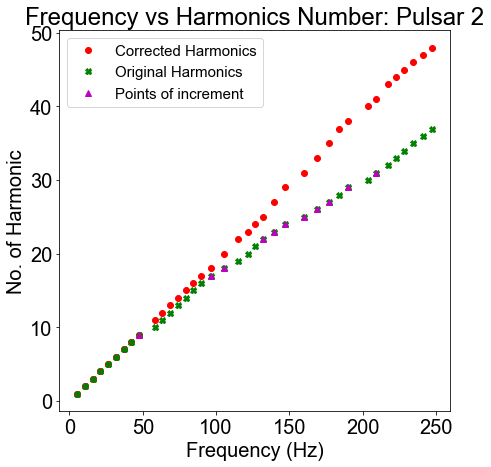

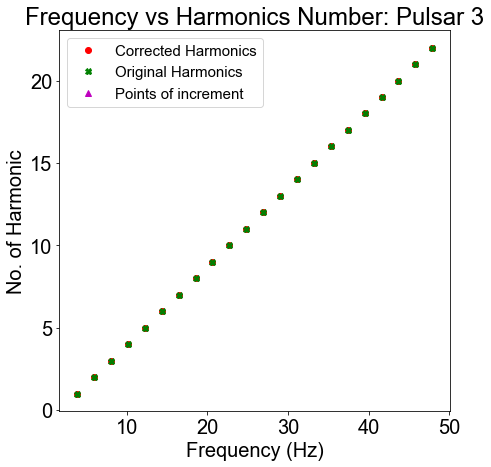

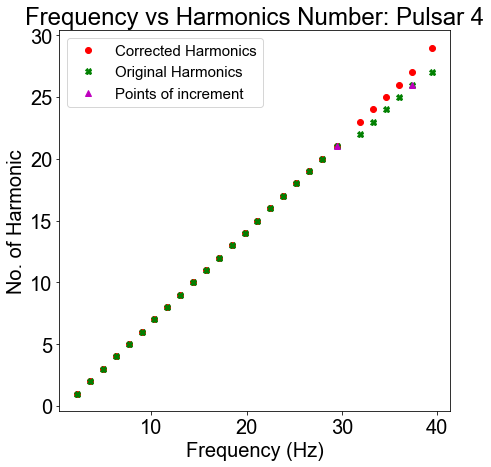

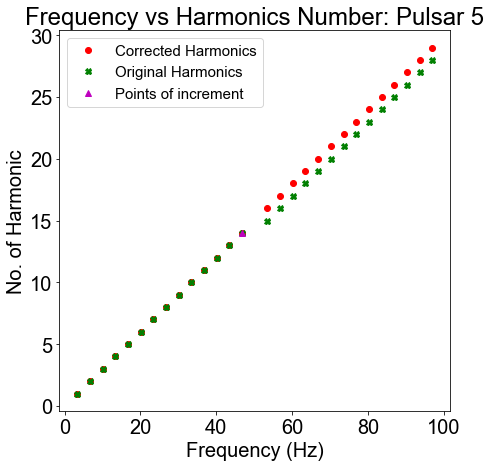

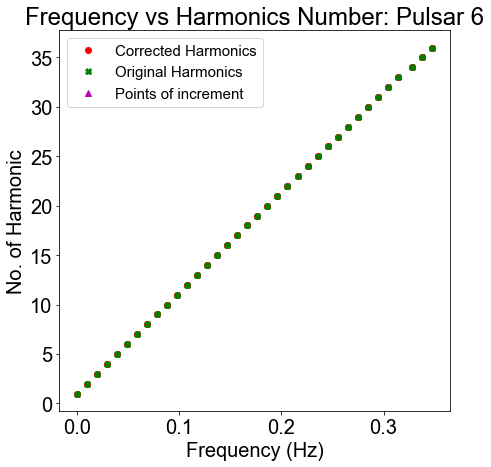

In [346]:
# printing out the difference in frequency arrays to do a manual check for missing harmonics
diff_freq0 = np.diff(f_peak0)
#print(diff_freq0)
diff_freq1i = np.diff(f_peak1i)
print(diff_freq1i)
diff_freq2ii = np.diff(f_peak2ii)
#print(diff_freq2ii)
diff_freq3ii = np.diff(f_peak3ii)
#print(diff_freq3ii)
diff_freq4ii = np.diff(f_peak4ii)
#print(diff_freq4ii)
diff_freq5 = np.diff(f_peak5)
#print(diff_freq5)

# calculates the new harmonics and the harmonic number
new_h_0, n_0  = correting_harmonic(f_peak0, '1', 5)
new_h_1i, n_1i = correting_harmonic(f_peak1i, '2', 7)
new_h_2ii, n_2ii = correting_harmonic(f_peak2ii, '3', 4)
new_h_3ii, n_3ii = correting_harmonic(f_peak3ii, '4', 2)
new_h_4ii, n_4ii = correting_harmonic(f_peak4ii, '5', 5)
new_h_5, n_5 = correting_harmonic(f_peak5, '6', 0.024)

### 1.6 Functions for fitting, P, and W calculation

In [371]:
def linear_fitting(frequency, harmonics, pulsar_no, res_f, err_f):
    """
    applies a linear fitting and calculates the chi-square
    
    @param frequency :: x input array
    @param harmonics :: y input array
    @param pulsar_no :: pulsar no. used while printing functions
    @param res_f :: minimum resolution of the bins, set as uncertainty in period
    @param err_f :: fitting error
    
    @returns harmonic_fit :: y best fit array 
    """
    # fitting
    (coef, covr) = np.polyfit(frequency, harmonics, 1, cov=True)
    eqn_of_fit = np.poly1d(coef)
    harmonic_fit = eqn_of_fit(frequency)
    err_p = np.sqrt(covr[0][0])
    
    # chi-sqaure
    res = harmonic_fit - harmonics
    chisq = sum(pow(res, 2))
    chisq_red = chisq/(len(harmonics)-2)
    
    print('Period of Pulsar %s: %.4f ± %.4f (res) ± %.4f (fit) seconds\n'%(pulsar_no, 
                                                                           coef[0], 
                                                                           res_f, 
                                                                           err_f))
    #print(' χ2: %.4f \n χ2 reduced: %.4f\n'%(chisq, chisq_red))
    return harmonic_fit, coef[0]            

def delete_points(arr1, arr2, m):
    """
    function deletes outliers
    @param arri (i=1,2) :: first array which is to be modifie
    @param m :: index of the element which is to be deleted
    
    @returns arri_ (i=1,2) :: new arr1 with the m index deleted
   """
    arr1_ = np.delete(arr1, m)
    arr2_ = np.delete(arr2, m)
    return arr1_, arr2_

def plot_fit(x, y, yfit, pulsar_no):    
    """
    plots (1) best fit and data, 
          (2) residuals
    
    @param x :: x array
    @param y :: y data array
    @param pulsar_no :: pulsar number used for formatting the strings (label)
    
    @return :: plots of best fit and residuals 
    """
    fig = plt.figure(figsize=(25,6.5))
    plt.subplot(121)
    plt.plot(x, y, 'bo', label='Data')
    plt.plot(x, yfit, 'r-', label='Best Fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Harmonics')             
    plt.title('Linear Fit: Pulsar %s'%(pulsar_no))
    plt.legend(loc='upper left', prop={'size': 15})
    
    res = y - yfit        
    plt.subplot(122)
    plt.plot(x, res, 'k*')
    plt.axhline(y=0., color='r', linestyle='-')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Residuals (Harmonics)')             
    plt.title('Residuals %s'%(pulsar_no))                
    plt.subplots_adjust(bottom=0.1, right=0.85)
    plt.show()  

def cal_width(period, new_harmonics, pulsar_no):
    """
    calculates the width of the pulse
    @param period :: period of the pulse
    @param new_harmonics :: corrected harmonics 
    @param pulsar_no :: pulsar number used for formatting string
    
    @return width :: width of the pulse
    """
    width = period/(2*new_harmonics)
    
    print('Width of Pulsar %s ~ (%.4f ± )s\n'%(pulsar_no, width))
    return width

### 2.5 Calculation of the period and fitting frequency vs harmonic plot


In [372]:
harm_fit0, p0 = linear_fitting(f_peak0[:-1], new_h_0[:-1], '1', res_f_0, 0.0002) 

# ------ deleted points, -15 --> -4 --> -5 : PULSAR 1 ------------------
#f_peak1i_, new_h_1i_ = delete_points(f_peak1i[:-15], new_h_1i[:-15], -4)
#f_peak1i_, new_h_1i_ = delete_points(f_peak1i_, new_h_1i_, -5)
harm_fit1, p1 = linear_fitting(f_peak1i_ , new_h_1i_, '2', res_f_1, 0.006) 

harm_fit2, p2 = linear_fitting(f_peak2ii, new_h_2ii, '3', res_f_2, 0.0008) 
harm_fit3, p3 = linear_fitting(f_peak3ii[:-7], new_h_3ii[:-7], '4', res_f_3, 0.0015) 
harm_fit4, p4 = linear_fitting(f_peak4ii[:-5], new_h_4ii[:-5], '5', res_f_4, 0.0006) 
harm_fit5, p5 = linear_fitting(f_peak5[1:-3]  , new_h_5[1:-3] , '6', res_f_5, 0.0006) 

Period of Pulsar 1: 0.2265 ± 0.0031 (res) ± 0.0002 (fit) seconds

Period of Pulsar 2: 0.1893 ± 0.0175 (res) ± 0.0060 (fit) seconds

Period of Pulsar 3: 0.4766 ± 0.0035 (res) ± 0.0008 (fit) seconds

Period of Pulsar 4: 0.7397 ± 0.0051 (res) ± 0.0015 (fit) seconds

Period of Pulsar 5: 0.2990 ± 0.0047 (res) ± 0.0006 (fit) seconds

Period of Pulsar 6: 101.9680 ± 0.0000 (res) ± 0.0006 (fit) seconds



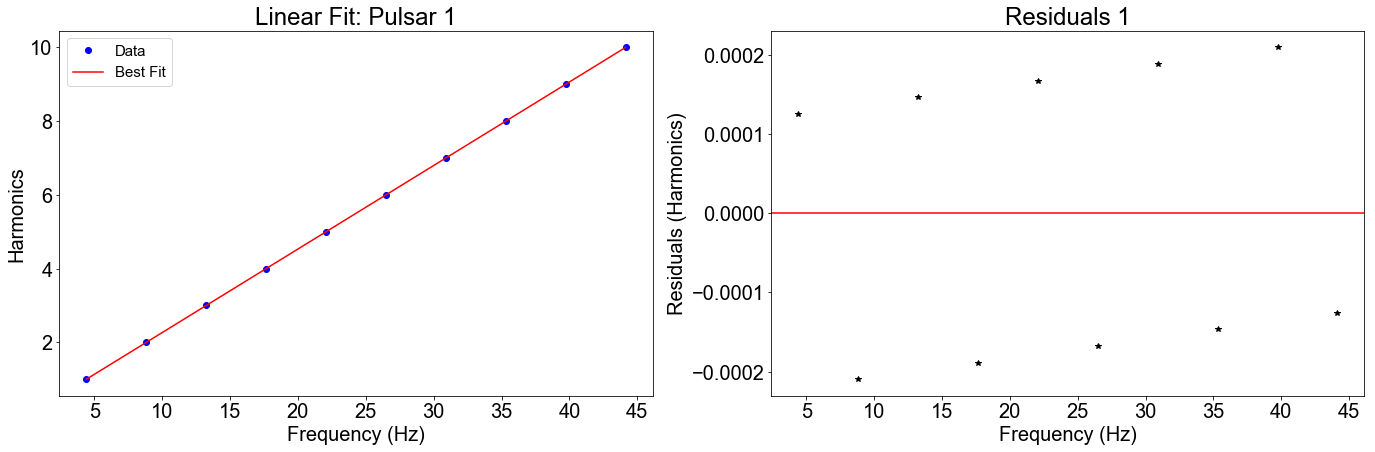

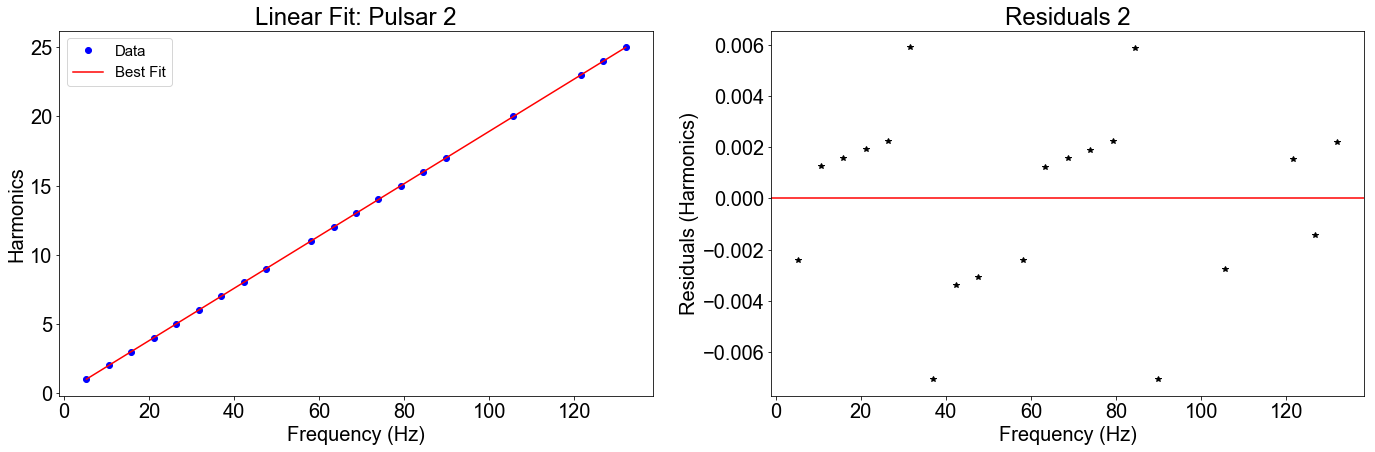

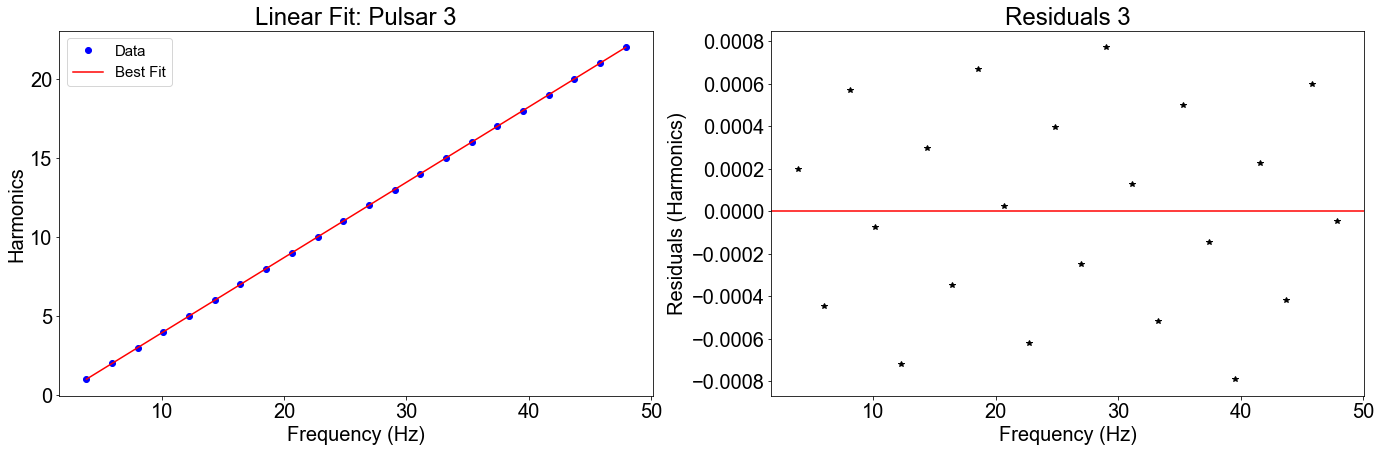

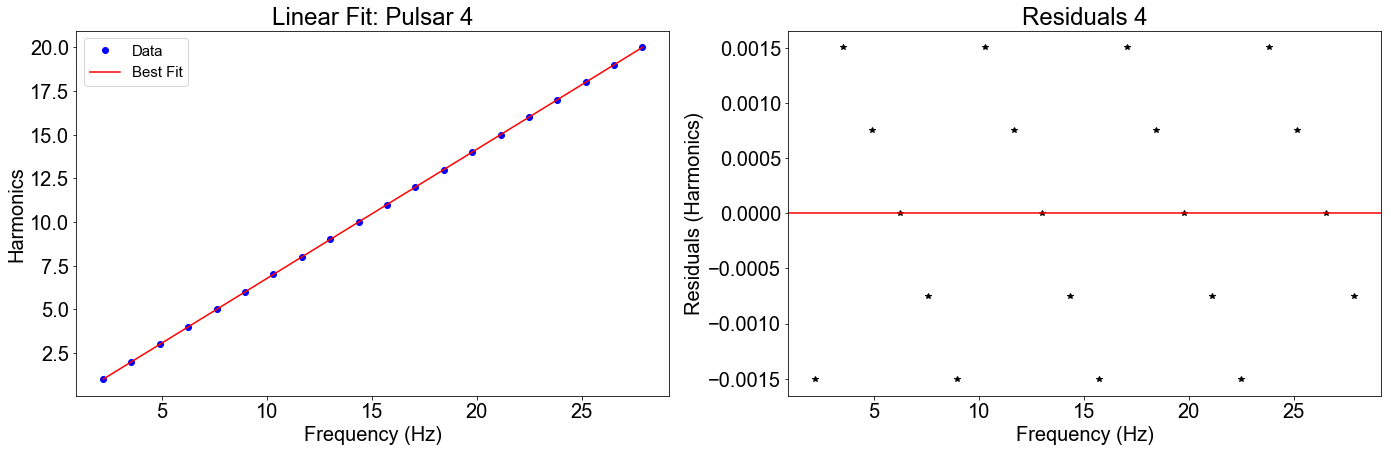

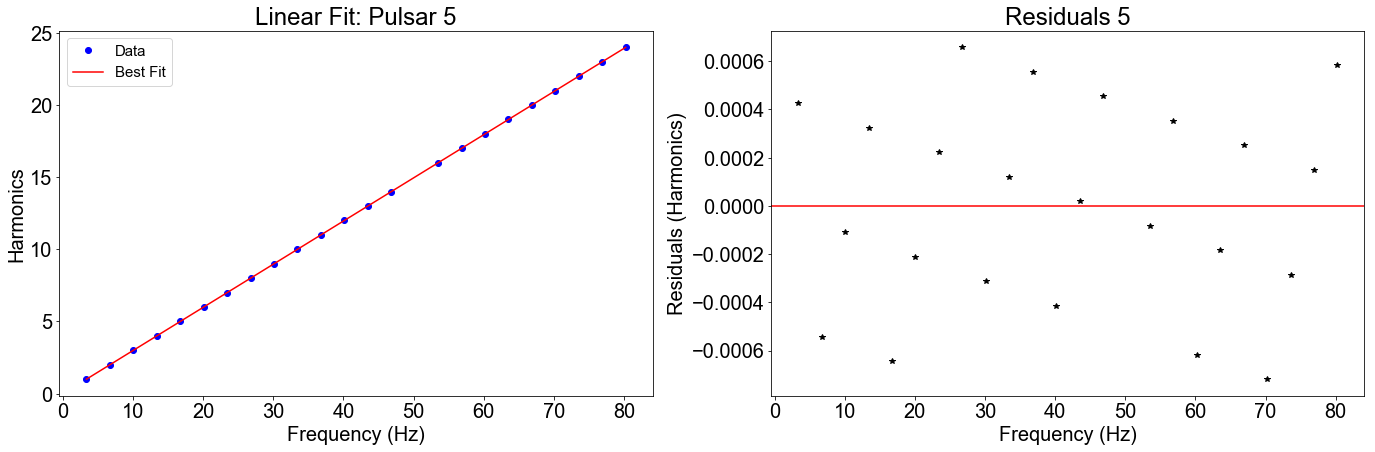

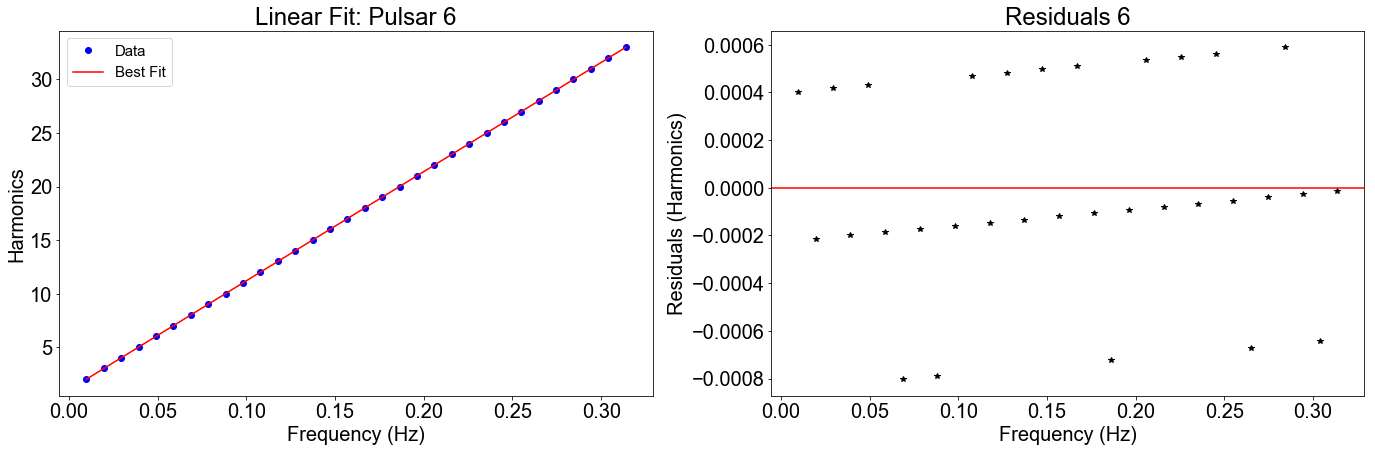

In [368]:
plot_fit(f_peak0[:-1], new_h_0[:-1], harm_fit0, '1') 
plot_fit(f_peak1i_ , new_h_1i_, harm_fit1, '2') 
plot_fit(f_peak2ii, new_h_2ii, harm_fit2, '3') 
plot_fit(f_peak3ii[:-7], new_h_3ii[:-7], harm_fit3, '4') 
plot_fit(f_peak4ii[:-5], new_h_4ii[:-5], harm_fit4, '5') 
plot_fit(f_peak5[1:-3]  , new_h_5[1:-3], harm_fit5, '6') 

### 2.5 Calculating the width of the pulsar

In [369]:
width0 = cal_width(p0 , new_h_0[:-1][-1],'0')
width1 = cal_width(p1 , new_h_1i_[-1],'1')
width2 = cal_width(p2 , new_h_2ii[-1],'2')
width3 = cal_width(p3 , new_h_3ii[:-7][-1],'3')
width4 = cal_width(p4 , new_h_4ii[:-5][-1],'4')
width5 = cal_width(p5 , new_h_5[1:-3][-1],'5')

Width of Pulsar 0 ~ (0.0113 ± )s

Width of Pulsar 1 ~ (0.0038 ± )s

Width of Pulsar 2 ~ (0.0108 ± )s

Width of Pulsar 3 ~ (0.0185 ± )s

Width of Pulsar 4 ~ (0.0062 ± )s

Width of Pulsar 5 ~ (1.5450 ± )s

